In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

DATAPATH = 'kolkata_daily_aqi.csv'

data = pd.read_csv(DATAPATH, index_col=['timestamp'], parse_dates=['timestamp'])
data.head(10)

,aqi,hour,day,month,day_of_week,is_weekend,aqi_lag_1h,aqi_lag_24h,aqi_lag_168h,rolling_mean_24h,rolling_std_24h
timestamp,,,,,,,,,,,
2018-04-18,65.70,18.50,18.0,4.0,2.0,0.0,65.10,98.50,70.20,66.36,23.63
2018-04-19,60.83,11.50,19.0,4.0,3.0,0.0,61.12,58.54,62.58,60.62,7.65
2018-04-20,59.64,10.86,20.0,4.0,4.0,0.0,59.68,60.91,65.77,60.40,4.90
2018-04-21,60.95,12.32,21.0,4.0,5.0,1.0,61.09,59.86,67.00,59.55,5.59
2018-04-22,59.58,11.50,22.0,4.0,6.0,1.0,59.08,60.67,80.58,60.02,7.97
2018-04-23,68.62,10.00,23.0,4.0,0.0,0.0,66.71,58.90,70.05,60.50,10.84
2018-04-24,99.22,19.00,24.0,4.0,1.0,0.0,102.22,56.89,66.67,77.44,25.93
2018-04-25,64.95,10.80,25.0,4.0,2.0,0.0,65.65,83.95,71.85,81.42,20.99
2018-04-26,66.36,13.50,26.0,4.0,3.0,0.0,65.64,68.43,63.71,64.74,6.06


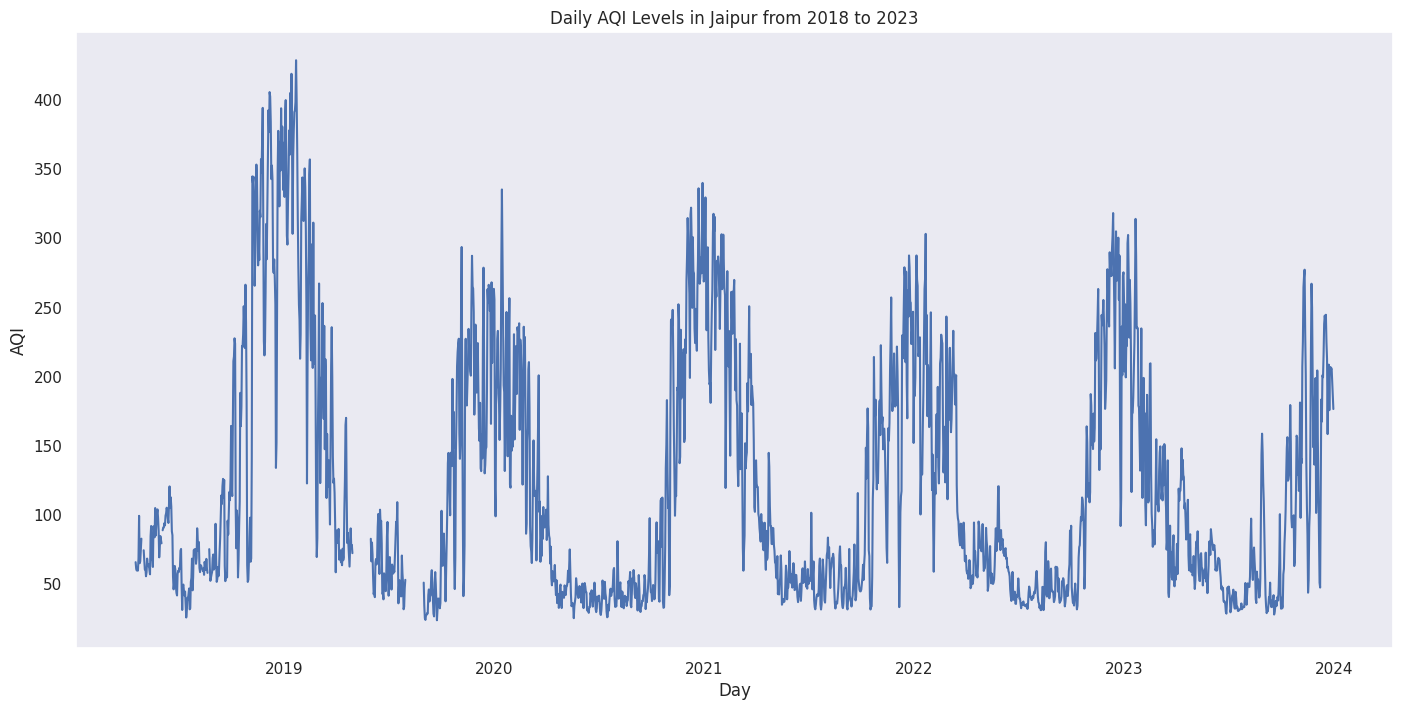

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(data['aqi'])
plt.title('Daily AQI Levels in Jaipur from 2018 to 2023')
plt.ylabel('AQI')
plt.xlabel('Day')
plt.grid(False)
plt.show()

In [ ]:
data['aqi'].dropna(inplace=True)

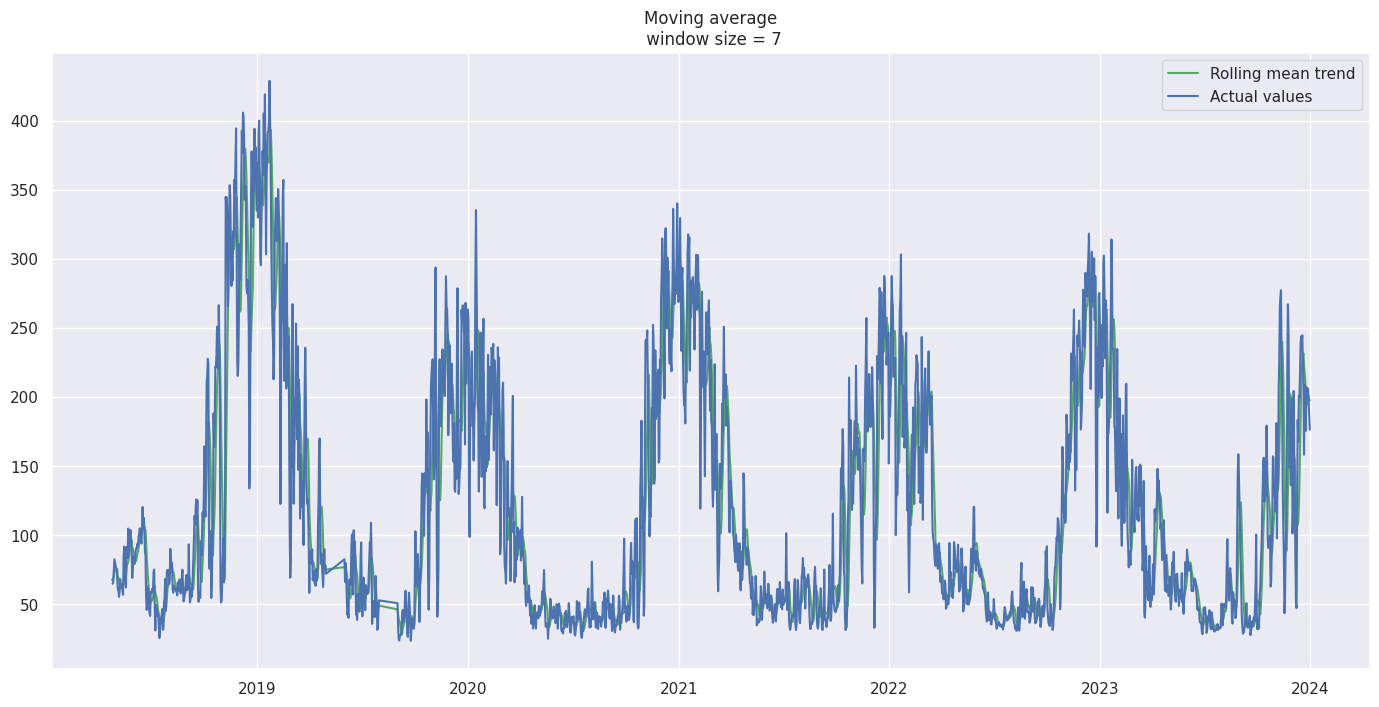

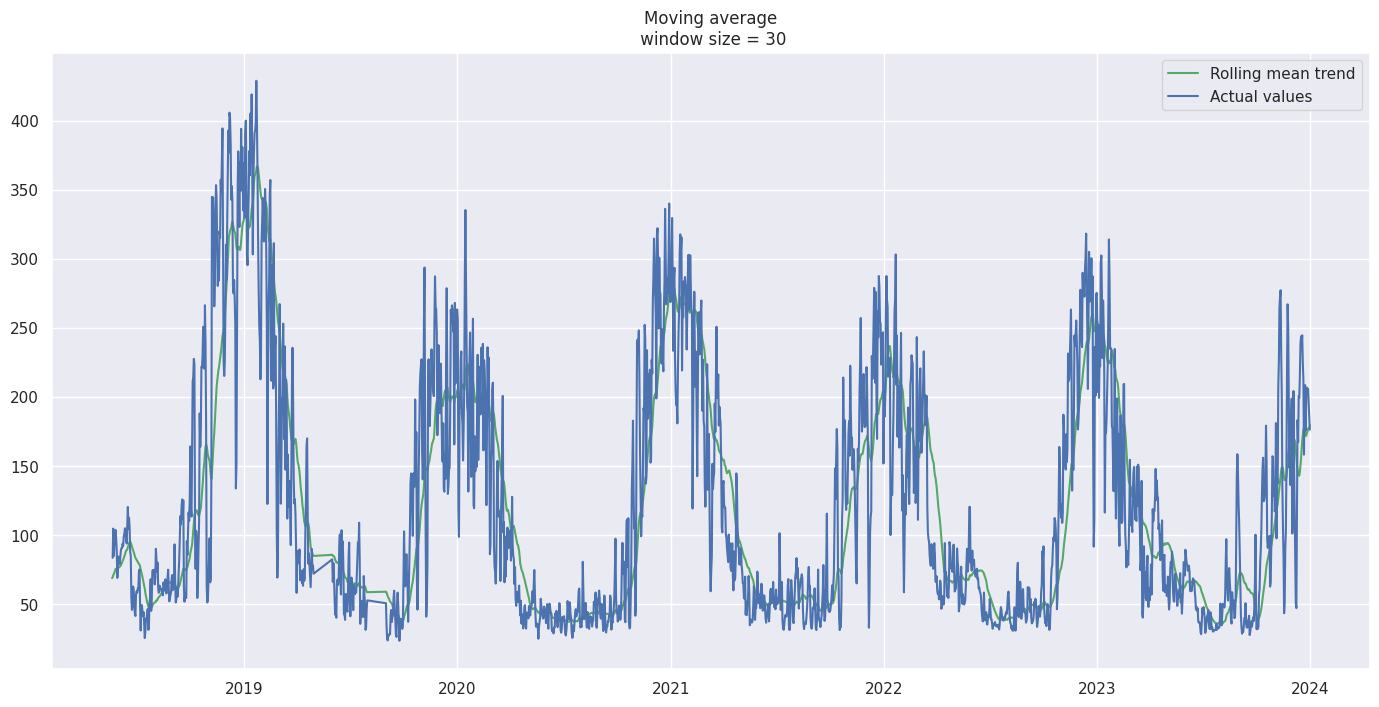

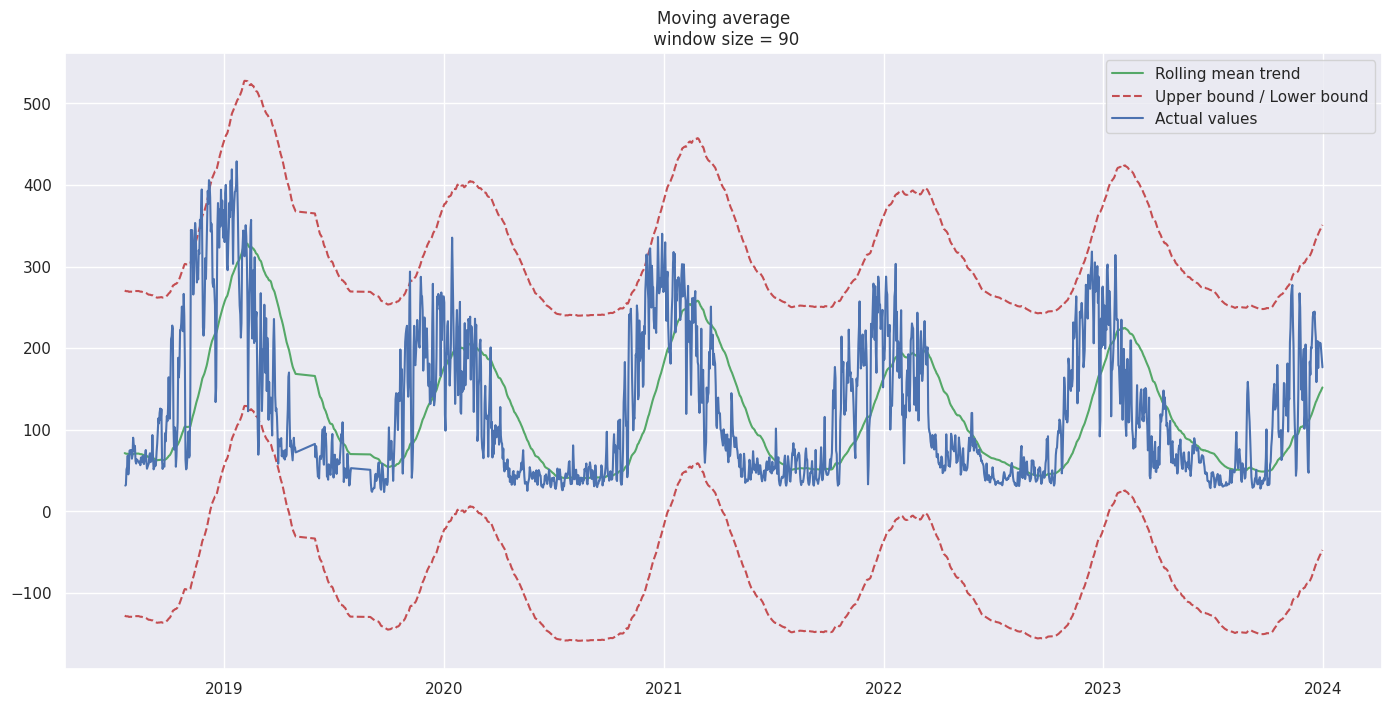

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 7 days (by week)
plot_moving_average(data.aqi.dropna(), 7)

#Smooth by the previous month (30 days)
plot_moving_average(data.aqi.dropna(), 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.aqi.dropna(), 90, plot_intervals=True)

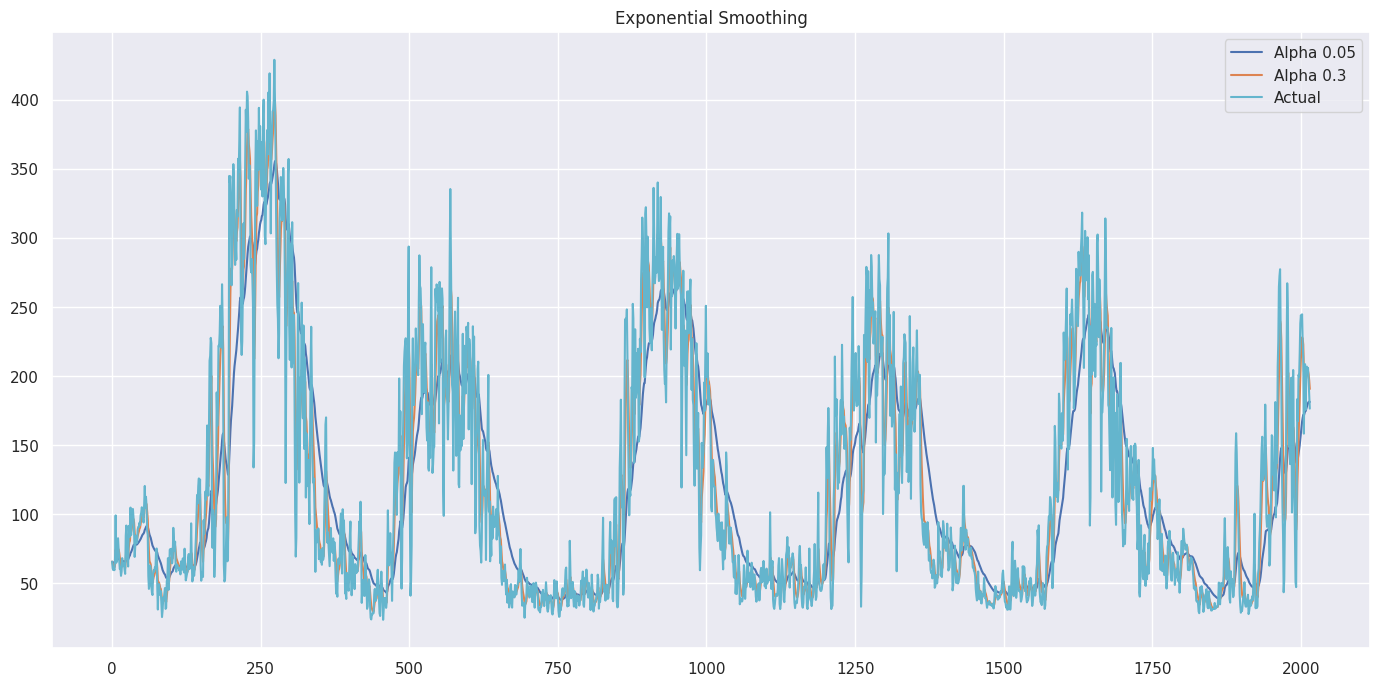

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.aqi.dropna(), [0.05, 0.3])

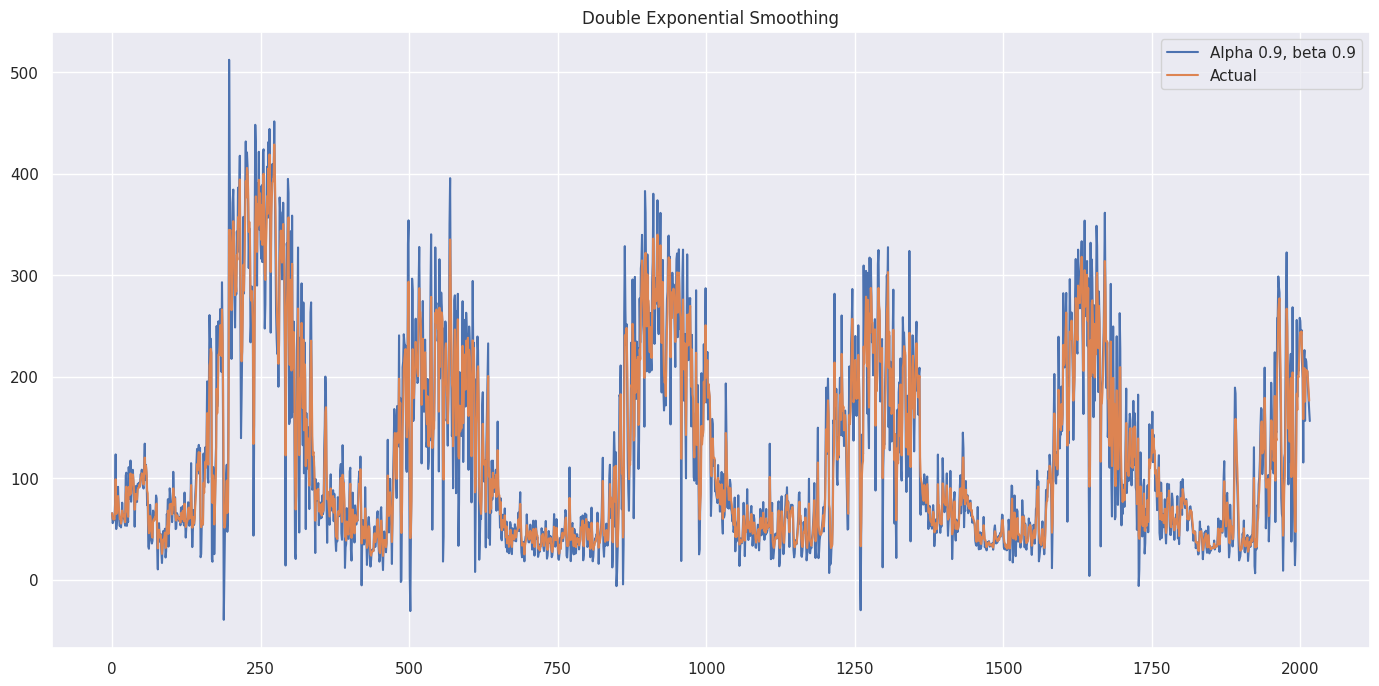

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):

    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
          if alpha==0.9 and beta==0.9:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.aqi.dropna(), alphas=[0.9, 0.02], betas=[0.9, 0.02])

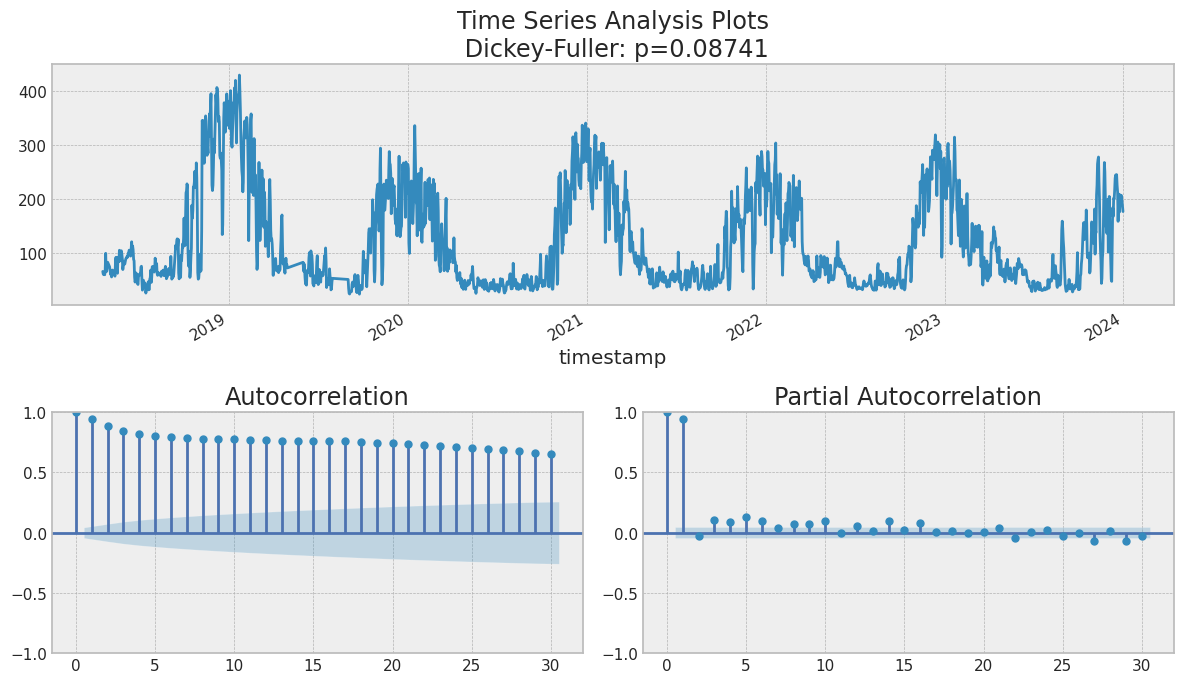

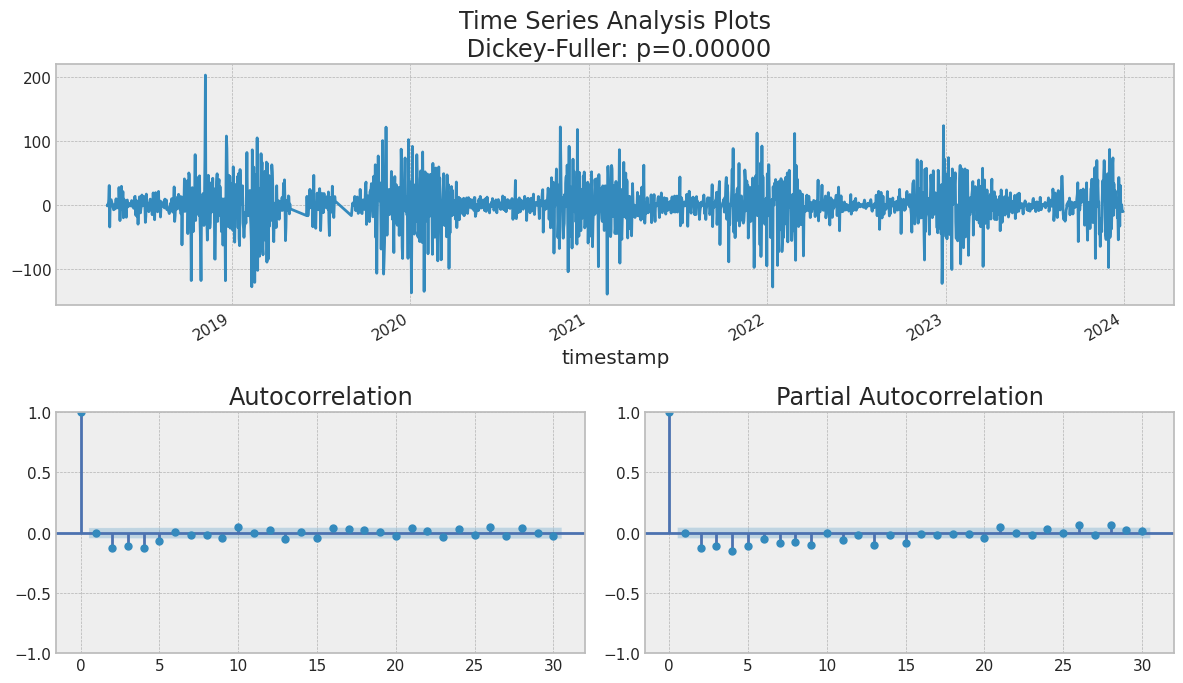

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):


    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(data.aqi.dropna(), lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.aqi - data.aqi.shift(1)

tsplot(data_diff.dropna()[1:], lags=30)

In [ ]:
ps = range(0,1)
d = 1
qs = range(3,4)
Ps = range(2,3)
D = 1
Qs = range(0,1)
s = 12

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.aqi, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.aqi, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/1 [00:00<?, ?it/s]

                                      SARIMAX Results                                      
Dep. Variable:                                 aqi   No. Observations:                 2084
Model:             SARIMAX(0, 1, 3)x(2, 1, [], 12)   Log Likelihood               -9888.167
Date:                             Fri, 22 Nov 2024   AIC                          19788.334
Time:                                     12:39:15   BIC                          19822.148
Sample:                                          0   HQIC                         19800.728
                                            - 2084                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1144      0.016     -7.098      0.000      -0.146      -0.083
ma.L2         -0.3486      

In [ ]:
forecasts = best_model.predict(365)

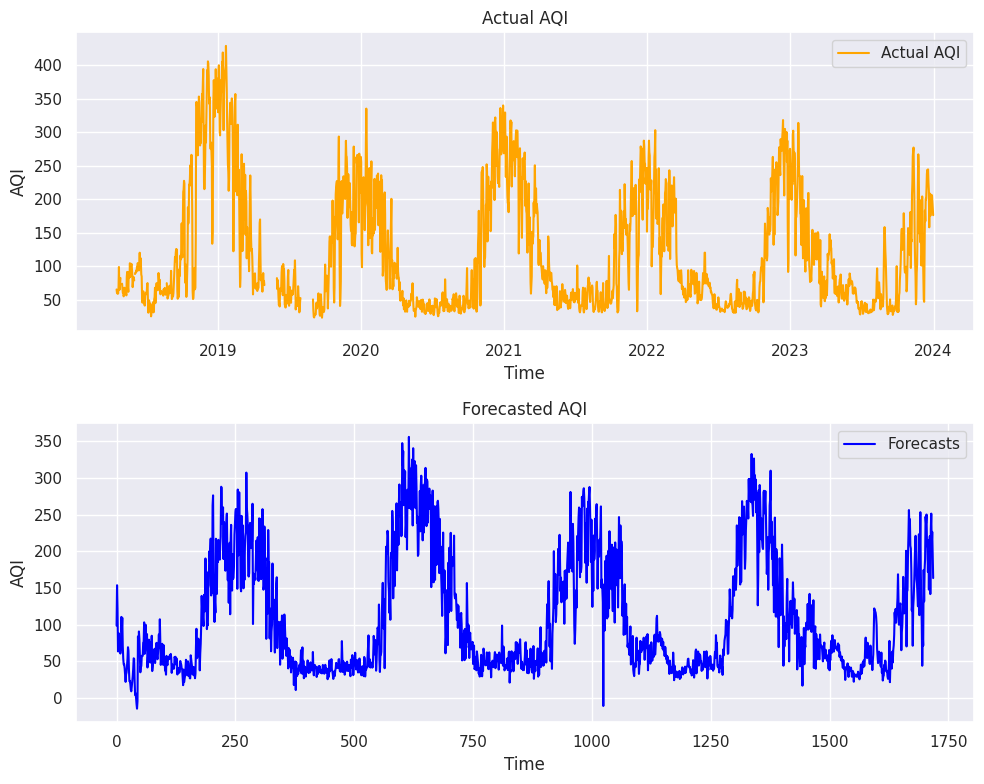

In [ ]:
import matplotlib.pyplot as plt

# Ensure your data's index is properly aligned with the expected timeline
# Assuming 'data' has a datetime index and forecasts are aligned properly

# Extract the x-axis values for `data.aqi`
x_actual = data.index  # Assuming `data` is a DataFrame with a datetime index
x_forecasts = range(len(forecasts))  # Or use a proper timeline if available

# Create two separate plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot actual AQI
ax[0].plot(x_actual, data.aqi, label='Actual AQI', color='orange')
ax[0].set_title('Actual AQI')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('AQI')
ax[0].legend()

# Plot forecasts
ax[1].plot(x_forecasts, forecasts, label='Forecasts', color='blue')
ax[1].set_title('Forecasted AQI')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('AQI')
ax[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


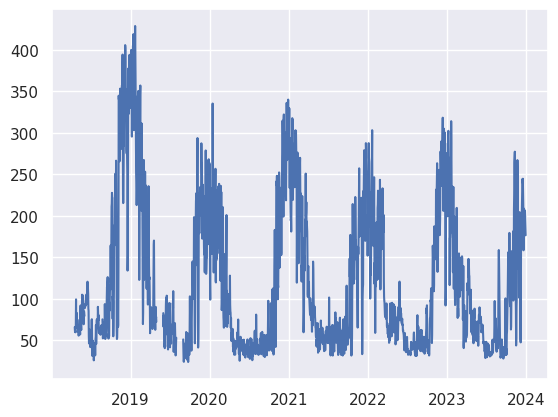

In [ ]:
plt.plot(data['aqi'])

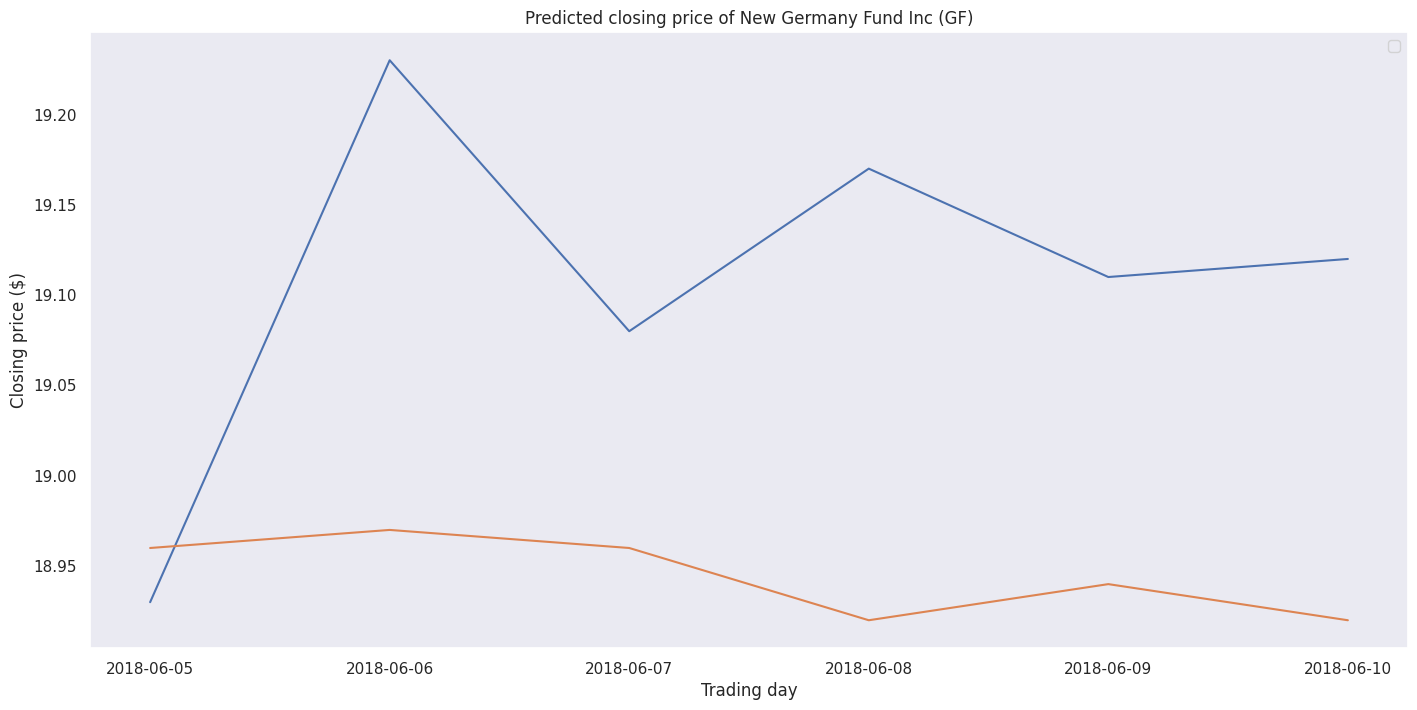

In [ ]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]},
                          index = pd.date_range(start='2018-06-05', periods=6,))


#Plot predicted vs actual price

plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.legend(loc='best')
plt.grid(False)
plt.show()

In [ ]:
forecasts

,predicted_mean
timestamp,
2019-04-18,98.765203
2019-04-19,153.707631
2019-04-20,121.663710
2019-04-21,63.618089
2019-04-22,88.737323
...,...
2023-12-27,251.235603
2023-12-28,207.177715
2023-12-29,226.394657


In [ ]:
forecasts.to_csv('forecasted_values_jaipur.csv')

In [ ]:
data['forecasted_value'] = forecasts

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
column_name = 'predicted_mean'
df = pd.read_csv('/content/forecasted_values_kolkata.csv')
# Count the number of NaN values in the specified column
nan_count = df[column_name].isna().sum()
nan_count

0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp

# Load datasets
actual_df = pd.read_csv('/content/kolkata_daily_aqi.csv')  # Replace with the actual file path
forecast_df = pd.read_csv('/content/forecasted_values_kolkata.csv')  # Replace with the forecast file path
forecast_df.rename(columns={'predicted_mean': 'aqi'}, inplace=True)
# Ensure timestamp is in datetime format
actual_df['timestamp'] = pd.to_datetime(actual_df['timestamp'])
forecast_df['timestamp'] = pd.to_datetime(forecast_df['timestamp'])


# Merge data on the timestamp column
merged_df = pd.merge(actual_df, forecast_df, on='timestamp', suffixes=('_actual', '_forecast'),how='right')

# Print merged DataFrame columns to debug
print("Merged DataFrame Columns:", merged_df.columns)

# Rename columns for clarity (if necessary)
if 'aqi_actual' in merged_df.columns and 'aqi_forecast' in merged_df.columns:
    merged_df.rename(columns={'aqi_actual': 'actual', 'aqi_forecast': 'forecast'}, inplace=True)

# Print final column names to ensure renaming worked
print("Final Merged DataFrame Columns:", merged_df.columns)

# Extract actual and forecast AQI values
actual_values = merged_df['actual']
forecast_values = merged_df['forecast']

# Calculate MSE
mse = mean_squared_error(actual_values, forecast_values)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAPE (with epsilon to avoid division by zero)
epsilon = 1e-5
mape = np.mean(np.abs((actual_values - forecast_values) / (actual_values + epsilon))) * 100

# Log-Likelihood for AIC/BIC calculation
n = len(actual_values)
residual = actual_values - forecast_values
log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(np.mean(residual**2)) + 1)

# Calculate AIC and BIC
aic = 2 - 2 * log_likelihood
bic = np.log(n) - 2 * log_likelihood

# Perform KS test
ks_stat, ks_p_value = ks_2samp(actual_values, forecast_values)

# Print results
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"AIC: {aic}")
print(f"BIC: {bic}")
print(f"KS Statistic: {ks_stat}")
print(f"KS Test P-value: {ks_p_value}")


    timestamp  aqi  hour  day  month  day_of_week  is_weekend  aqi_lag_1h  \
11        NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
12        NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
13        NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
46        NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
126       NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
..        ...  ...   ...  ...    ...          ...         ...         ...   
496       NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
497       NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
498       NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
499       NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   
500       NaT  NaN   NaN  NaN    NaN          NaN         NaN         NaN   

     aqi_lag_24h  aqi_lag_168h  rolling_mean_24h  rolling_std_24h  
11     

ValueError: Input contains NaN.

In [ ]:
# Check how many NaNs appear after merge
print(merged_df.isna().sum())

# Look at rows with NaN values to investigate further
print(merged_df[merged_df.isna().any(axis=1)])


timestamp           4216
actual              4216
hour                4216
day                 4216
month               4216
day_of_week         4216
is_weekend          4216
aqi_lag_1h          4216
aqi_lag_24h         4216
aqi_lag_168h        4216
rolling_mean_24h    4216
rolling_std_24h     4216
forecast               0
dtype: int64
     timestamp  actual  hour  day  month  day_of_week  is_weekend  aqi_lag_1h  \
13         NaT     NaN   NaN  NaN    NaN          NaN         NaN         NaN   
14         NaT     NaN   NaN  NaN    NaN          NaN         NaN         NaN   
15         NaT     NaN   NaN  NaN    NaN          NaN         NaN         NaN   
16         NaT     NaN   NaN  NaN    NaN          NaN         NaN         NaN   
17         NaT     NaN   NaN  NaN    NaN          NaN         NaN         NaN   
...        ...     ...   ...  ...    ...          ...         ...         ...   
4285       NaT     NaN   NaN  NaN    NaN          NaN         NaN         NaN   
4286       NaT

In [ ]:
merged_df

,timestamp,actual,hour,day,month,day_of_week,is_weekend,aqi_lag_1h,aqi_lag_24h,aqi_lag_168h,rolling_mean_24h,rolling_std_24h,predicted_mean,forecast
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.676099,70.676099
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.107192,54.107192
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.994709,45.994709
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.903912,45.903912
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.437323,40.437323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5868,2023-12-27,205.42,11.5,27.0,12.0,2.0,0.0,206.83,206.88,212.71,205.99,68.87,251.235603,251.235603
5869,2023-12-28,205.88,11.5,28.0,12.0,3.0,0.0,203.88,205.42,158.38,201.24,60.42,207.177715,207.177715
5870,2023-12-29,195.71,11.5,29.0,12.0,4.0,0.0,198.04,205.88,201.54,205.66,68.08,226.394657,226.394657
5871,2023-12-30,186.29,11.5,30.0,12.0,5.0,1.0,187.58,195.71,208.62,189.77,59.10,193.656412,193.656412


In [ ]:
import pandas as pd

# Load the CSV files into dataframes
file1 = "/content/forecasted_values_jaipur.csv"
file2 = "/content/jaipur_daily_aqi.csv"

df1 = pd.read_csv(file1, parse_dates=True, index_col='timestamp')
df2 = pd.read_csv(file2, parse_dates=True, index_col='timestamp')

# Align dataframes on the common timestamps using join
# Keeping only rows where both dataframes have data (inner join)
result_df = df1[['predicted_mean']].join(df2[['aqi']], how='inner', lsuffix='1', rsuffix='2')

# Rename the columns for clarity
result_df.rename(columns={'predicted_mean': 'aqi1', 'aqi': 'aqi2'}, inplace=True)

# Output the resulting dataframe
result_df

,aqi1,aqi2
timestamp,,
2019-01-08,139.813621,155.58
2019-01-09,172.635335,147.96
2019-01-10,158.018875,153.67
2019-01-11,167.114230,97.79
2019-01-12,151.301639,162.25
...,...,...
2023-12-27,277.046413,202.54
2023-12-28,196.939031,244.12
2023-12-29,243.615037,247.58


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kstest, norm

# Example actual and forecasted data as pandas Series
# Replace these with your actual and forecasted values
actual = result_df['aqi2']
forecasted = result_df['aqi1']

# Ensure the series are aligned
assert actual.shape == forecasted.shape, "Actual and forecasted values must have the same length."

# Residuals
residuals = actual - forecasted
n = len(actual)  # Number of data points
k = 1  # Number of parameters in the model (adjust based on your model complexity)

# AIC: Akaike Information Criterion
log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(np.var(residuals)) + 1)
aic = 2 * k - 2 * log_likelihood

# BIC: Bayesian Information Criterion
bic = k * np.log(n) - 2 * log_likelihood

# MAPE: Mean Absolute Percentage Error
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

# KS Test: Kolmogorov-Smirnov Test
ks_stat, ks_p_value = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))

# Display the results
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"MAPE: {mape}")
print(f"KS Test Statistic: {ks_stat:.2f}")
print(f"KS Test p-value: {ks_p_value:.3f}")
if ks_p_value < 0.05:
    print("Residuals do NOT follow a normal distribution (reject H0).")
else:
    print("Residuals follow a normal distribution (fail to reject H0).")

AIC: 17234.01
BIC: 17239.46
MAPE: 21.921103751907463
KS Test Statistic: 0.06
KS Test p-value: 0.000
Residuals do NOT follow a normal distribution (reject H0).


In [ ]:
from tabulate import tabulate

# Data for the table
data = [
    ["17234.01", "17239.46", "21.92","Fail to reject H0"],

]

# Column headers
headers = ["AIC", "BIC", "MAPE","KS Test"]

# Generate the table
table = tabulate(data, headers, tablefmt="grid")

# Print the table
print(table)


+-------+---------+--------+-------------------+
|   AIC |     BIC |   MAPE | KS Test           |
+=======+=========+========+===================+
| 17234 | 17239.5 |  21.92 | Fail to reject H0 |
+-------+---------+--------+-------------------+


In [ ]:
import pandas as pd

# Load the CSV files into dataframes
file1 = "/content/forecasted_values_kolkata.csv"
file2 = "/content/kolkata_daily_aqi.csv"

df1 = pd.read_csv(file1, parse_dates=True, index_col='timestamp')
df2 = pd.read_csv(file2, parse_dates=True, index_col='timestamp')

# Align dataframes on the common timestamps using join
# Keeping only rows where both dataframes have data (inner join)
result_df = df1[['predicted_mean']].join(df2[['aqi']], how='inner', lsuffix='1', rsuffix='2')

# Rename the columns for clarity
result_df.rename(columns={'predicted_mean': 'aqi1', 'aqi': 'aqi2'}, inplace=True)

# Output the resulting dataframe
result_df

<ipython-input-12-778719fa88d1>:8: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df2 = pd.read_csv(file2, parse_dates=True, index_col='timestamp')


,aqi1,aqi2
timestamp,,
2019-04-18,98.765203,164.92
2019-04-19,153.707631,170.12
2019-04-20,121.663710,114.46
2019-04-21,63.618089,79.54
2019-04-22,88.737323,86.96
...,...,...
2023-12-27,251.235603,205.42
2023-12-28,207.177715,205.88
2023-12-29,226.394657,195.71


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kstest, norm

# Example actual and forecasted data as pandas Series
# Replace these with your actual and forecasted values
actual = result_df['aqi2']
forecasted = result_df['aqi1']

# Ensure the series are aligned
assert actual.shape == forecasted.shape, "Actual and forecasted values must have the same length."

# Residuals
residuals = actual - forecasted
n = len(actual)  # Number of data points
k = 1  # Number of parameters in the model (adjust based on your model complexity)

# AIC: Akaike Information Criterion
log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(np.var(residuals)) + 1)
aic = 2 * k - 2 * log_likelihood

# BIC: Bayesian Information Criterion
bic = k * np.log(n) - 2 * log_likelihood

# MAPE: Mean Absolute Percentage Error
mape = np.mean(np.abs((actual - forecasted) / actual)) * 100

# KS Test: Kolmogorov-Smirnov Test
ks_stat, ks_p_value = kstest(residuals, 'norm', args=(np.mean(residuals), np.std(residuals)))

# Display the results
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"MAPE: {mape}")
print(f"KS Test Statistic: {ks_stat:.2f}")
print(f"KS Test p-value: {ks_p_value:.3f}")
if ks_p_value < 0.05:
    print("Residuals do NOT follow a normal distribution (reject H0).")
else:
    print("Residuals follow a normal distribution (fail to reject H0).")

AIC: 57081.81
BIC: 57088.49
MAPE: 21.849603789342073
KS Test Statistic: nan
KS Test p-value: nan
Residuals follow a normal distribution (fail to reject H0).


In [ ]:
from tabulate import tabulate

# Data for the table
data = [
    ["57081.81", "57088.49", "21.849603789342073","Fail to reject H0"],

]

# Column headers
headers = ["AIC", "BIC", "MAPE","KS Test"]

# Generate the table
table = tabulate(data, headers, tablefmt="grid")

# Print the table
print(table)


+---------+---------+---------+-------------------+
|     AIC |     BIC |    MAPE | KS Test           |
+=========+=========+=========+===================+
| 57081.8 | 57088.5 | 21.8496 | Fail to reject H0 |
+---------+---------+---------+-------------------+
